#  Policy Gradients

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р. С., Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* Лю Ю. (Х.) Обучение с подкреплением на PyTorch: сборник рецептов / пер. с англ. А. А. Слинкина. – М.: ДМК Пресс, 2020
* https://www.youtube.com/watch?v=_x0ASf9jV9U&ab_channel=sim0nsays
* https://karpathy.github.io/2016/05/31/rl/
* https://neerc.ifmo.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_policy_gradient_%D0%B8_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B0%D1%81%D0%B8%D0%BD%D1%85%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%B0-%D0%BA%D1%80%D0%B8%D1%82%D0%B8%D0%BA%D0%B0
* https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html
* https://huggingface.co/learn/deep-rl-course/unit4/introduction
* https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#:~:text=The%20goal%20of%20reinforcement%20learning,and%20optimizing%20the%20policy%20directly.

## Задачи для совместного разбора

1\. Рассмотрите основные шаги по формированию обучающей выборки для использования алгоритмов Policy Gradients.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
state_dim = 5
n_actions = 3

state = th.rand(state_dim)

In [ ]:
model = nn.Sequential(
    nn.Linear(in_features=state_dim, out_features=n_actions),
    nn.Softmax()
)

In [ ]:
preds = model(state)
preds

tensor([0.2935, 0.4442, 0.2623], grad_fn=<SoftmaxBackward0>)

In [ ]:
action = th.multinomial(preds, 1).item()
action

1

In [ ]:
log_prob = preds[action].log()
log_prob

tensor(-0.8114, grad_fn=<LogBackward0>)

In [ ]:
# reset state
log_probs = []
rewards = []

for _ in range(10):
  preds = model(state)
  action = th.multinomial(preds, 1).item()
  log_prob = preds[action].log()
  r = th.rand(1)
  rewards.append(r.item())
  log_probs.append(log_prob)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите классы `Policy` для реализации модели политики и `Trainer` для реализации процесса обучения модели при помощи алгоритма REINFORCE. Настройте агента для игры в окружении `CartPole-v1`. Визуализируйте динамику значений награды на эпизод в процессе обучения. Сыграйте эпизод, используя обученного агента, и убедитесь, что агент выучивается, как стабилизировать шест.

$$L_{PG} = -\sum_{i}{R_iln(p(a_i|s_i))}$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.


- [ ] Проверено на семинаре

In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.8 MB/s eta 0:00:00


In [ ]:
import torch as th
import gymnasium as gym
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

In [ ]:
from dataclasses import dataclass
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

In [ ]:
policy_cfg = PolicyConfig(4, 2, 300)

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(in_features=self.cfg.n_state, out_features=self.cfg.n_hidden),
            nn.ReLU(),
            nn.Linear(in_features=self.cfg.n_hidden, out_features=self.cfg.n_action),
            nn.Softmax()
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, state: th.Tensor) -> tuple[int, float]:
        # возвращает действие пропорционально вероятностям, полученным при помощи модели
        # и логарифм вероятности выбранного действия
        preds = self.model(state)
        action = th.multinomial(preds, 1).item()
        return action, preds[action].log()

In [ ]:
@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: float = 400

In [ ]:
class Trainer:
  def __init__(self, env: gym.Env, config: TrainConfig, policy: PolicyNetwork):
    self.cfg = config
    self.env = env
    self.policy = policy
    self.optimizer = optim.Adam(self.policy.model.parameters(), lr=self.cfg.learning_rate)

  def run_episode(self):
    log_probs = []
    rewards = []
    state, info = self.env.reset()
    done = False
    while not done:
      action, log_prob = self.policy.get_action(th.tensor(state))
      state, reward, trunc, term, info = self.env.step(action)
      done = trunc or term
      rewards.append(reward)
      log_probs.append(log_prob)
    return rewards, log_probs

  def visualize(self):
    fig, ax = plt.subplots()
    ax.plot(self.rewards_per_ep)
    plt.title('Rewards per episode')
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.show()

  def R_t_hugging_face(self, rewards):
    returns = deque(maxlen=500)
    n_steps = len(rewards)
    for t in range(n_steps)[::-1]:
      disc_return_t = returns[0] if len(returns) > 0 else 0
      returns.appendleft(self.cfg.gamma * disc_return_t + rewards[t])
    return th.tensor(returns)

  def policy_loss(self, log_probs, R_t):
    policy_loss = []
    for log_prob, disc_return in zip(log_probs, R_t):
      policy_loss.append((-log_prob * disc_return).unsqueeze(0))
    policy_loss = th.cat(policy_loss).sum()
    return policy_loss

  def train(self):
    self.rewards_per_ep = []
    for ep in range(1, self.cfg.episode_num + 1):
      rewards, log_probs = self.run_episode()
      self.rewards_per_ep.append(sum(rewards))

      R_t = self.R_t_hugging_face(rewards)
      loss = self.policy_loss(log_probs, R_t)

      loss.backward()
      self.optimizer.step()
      self.optimizer.zero_grad()
      if ep % (self.cfg.episode_num // 10) == 0:
        print(f'{ep=} loss={loss:.5f}')

In [ ]:
env = gym.make('CartPole-v1')
trainer = Trainer(
    env,
    TrainConfig(),
    PolicyNetwork(policy_cfg)
)
trainer.train()

ep=40 loss=84.62079
ep=80 loss=667.70471
ep=120 loss=446.64453
ep=160 loss=542.54865
ep=200 loss=2738.79297
ep=240 loss=11174.97852
ep=280 loss=8590.39160
ep=320 loss=4646.13379
ep=360 loss=7554.91748
ep=400 loss=7615.81055


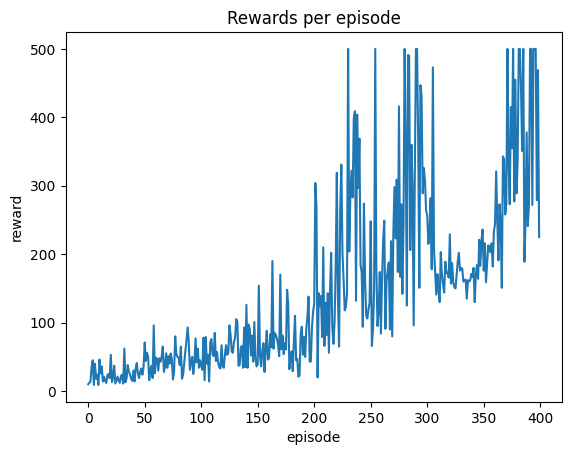

In [ ]:
trainer.visualize()

In [ ]:
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), 'video')
state, info = env.reset()
done = False
action_count = 0

while not done:
  env.render()
  action = trainer.policy.get_action(th.tensor(state))[0]
  action_count += 1
  state, reward, trunc, term, info = env.step(action)
  done = trunc or term
env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


In [ ]:
action_count

500

<p class="task" id="2"></p>

2\. Повторите решение задачи 1, делая шаг обучения не после одного эпизода, а по результату прогонов нескольких эпизодов. Обратите внимание, что после обновления весов модели все старые данные для обучения становятся неактуальными и должны быть удалены.

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class TrainConfigBatch:
    gamma: float = 0.99
    batch_size: int = 32
    learning_rate: float = 0.001
    episode_num: float = 400

In [ ]:
class TrainerBatch(Trainer):
  def __init__(self, env: gym.Env, config: TrainConfig, policy: PolicyNetwork):
    super().__init__(env, config, policy)

  def train(self):
    self.rewards_per_ep = []
    batch = 0
    losses = []
    loss = 0
    for ep in range(1, self.cfg.episode_num+1):
      rewards, log_probs = self.run_episode()
      self.rewards_per_ep.append(sum(rewards))
      batch += 1
      R_t = self.R_t_hugging_face(rewards)
      losses.append(self.policy_loss(log_probs, R_t).unsqueeze(0))
      if batch == self.cfg.batch_size:
        loss = th.cat(losses).sum()
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        batch = 0
        losses = []
      if ep % (self.cfg.episode_num // 10) == 0:
        print(f'{ep=} loss={loss:.5f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ep=40 loss=4998.00293
ep=80 loss=8970.92188
ep=120 loss=8095.60498
ep=160 loss=8679.80469
ep=200 loss=9620.11523
ep=240 loss=11507.68555
ep=280 loss=13239.39844
ep=320 loss=15737.04980
ep=360 loss=13498.56543
ep=400 loss=11544.11230


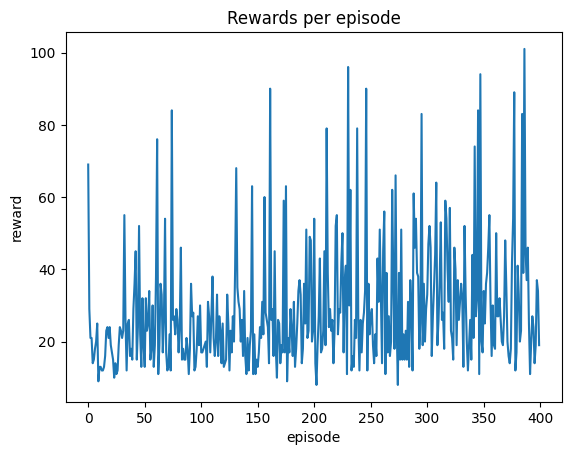

In [ ]:
env = gym.make('CartPole-v1')
trainer = TrainerBatch(
    env,
    TrainConfigBatch(),
    PolicyNetwork(policy_cfg)
)
trainer.train()
trainer.visualize()

In [ ]:
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), 'video')
state, info = env.reset()
done = False
action_count = 0

while not done:
  env.render()
  action = trainer.policy.get_action(th.tensor(state))[0]
  action_count += 1
  state, reward, trunc, term, info = env.step(action)
  done = trunc or term
env.close()

<p class="task" id="3"></p>

3\. Повторите решение задачи 1, реализовав алгоритм REINFONCE с baseline.

$$L_{PG} = -\sum_{i}{A_ip(a_i|s_i)}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи двух независимых сетей. Сеть для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Сеть для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Настройка весов обеих моделей происходит после каждого эпизода.

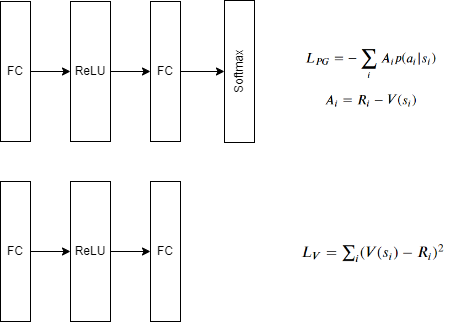

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: float = 400

In [ ]:
class PolicyNetworkBaseline(PolicyNetwork):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__(policy_config)
        self.model_base = nn.Sequential(
            nn.Linear(self.cfg.n_state, out_features=self.cfg.n_hidden),
            nn.ReLU(),
            nn.Linear(in_features=self.cfg.n_hidden, out_features=1)
        )

In [ ]:
class TrainerBaseline(Trainer):
  def __init__(self, env: gym.Env, config: TrainConfig, policy: PolicyNetwork):
    super().__init__(env, config, policy)
    self.crit_base = nn.MSELoss()
    self.optimizer_base = optim.Adam(self.policy.model_base.parameters(), lr=self.cfg.learning_rate)

  def run_episode(self):
    log_probs = []
    rewards = []
    states = []
    state, info = self.env.reset()
    done = False
    while not done:
      action, log_prob = self.policy.get_action(th.tensor(state))
      state, reward, trunc, term, info = self.env.step(action)
      done = trunc or term
      rewards.append(reward)
      states.append(state)
      log_probs.append(log_prob)
    return rewards, th.tensor(states), log_probs

  def train(self):
    self.rewards_per_ep = []
    for ep in range(1, self.cfg.episode_num + 1):
      rewards, states, log_probs = self.run_episode()
      self.rewards_per_ep.append(sum(rewards))

      R_t = self.R_t_hugging_face(rewards)
      V_t = self.policy.model_base(states)
      L_v = self.crit_base(th.flatten(V_t), R_t)
      L_v.backward()
      self.optimizer_base.step()
      self.optimizer_base.zero_grad()

      A_t = R_t - V_t.detach()
      loss = self.policy_loss(log_probs, A_t)
      loss.backward()
      self.optimizer.step()
      self.optimizer.zero_grad()
      if ep % (self.cfg.episode_num // 10) == 0:
        print(f'{ep=} loss={loss:.5f}')

ep=40 loss=1589.14124
ep=80 loss=248.35179
ep=120 loss=1931.03088
ep=160 loss=96746.10938
ep=200 loss=284.36258
ep=240 loss=73952.01562
ep=280 loss=352238.12500
ep=320 loss=8729.77734
ep=360 loss=-4684.43652
ep=400 loss=-5375.43945


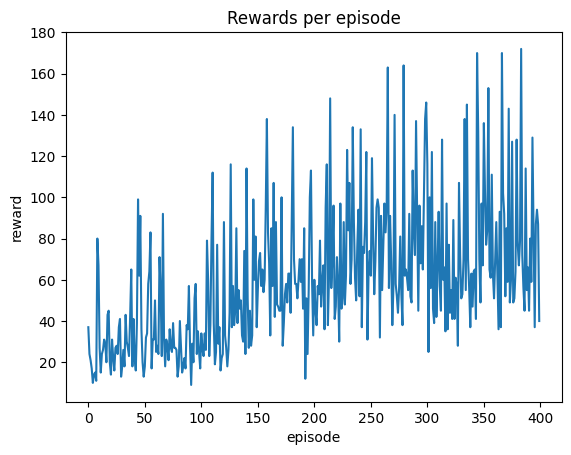

In [ ]:
env = gym.make('CartPole-v1')
trainer = TrainerBaseline(
    env,
    TrainConfig(),
    PolicyNetworkBaseline(policy_cfg)
)
trainer.train()
trainer.visualize()

In [ ]:
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), 'video', video_length=10000)
state, info = env.reset()
done = False
actions_to_lose = 0

while not done:
  env.render()
  action = trainer.policy.get_action(th.tensor(state))[0]
  actions_to_lose += 1
  state, reward, trunc, term, info = env.step(action)
  done = trunc or term
env.close()
actions_to_lose

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


86

<p class="task" id="4"></p>

4\. Повторите решение задачи 1, реализовав алгоритм Actor-Critic

$$L_{PG} = -\sum_{i}{A_ip(a_i|s_i)}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи одной сети в двумя головами. Голова для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Голова для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Итоговая функции потерь для настройки представляет из себя сумму функций потерь для голов: $L = L_{PG} + L_{V}$.

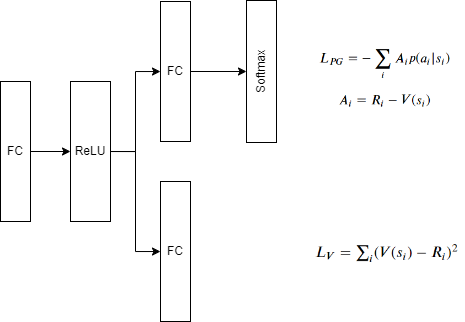

- [ ] Проверено на семинаре

In [ ]:
class Model(nn.Module):
  def __init__(self, n_state, n_hidden, n_actions):
    super().__init__()
    self.fc_main = nn.Linear(n_state, out_features=n_hidden)
    self.fc_pg = nn.Linear(in_features=n_hidden, out_features=n_actions)
    self.fc_v = nn.Linear(in_features=n_hidden, out_features=1)

  def forward(self, X):
    out = self.fc_main(X).relu()
    pg = self.fc_pg(out).softmax(dim=-1)
    v = self.fc_v(out)
    return pg, v

In [ ]:
@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: float = 400

In [ ]:
class PolicyNetworkAC(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = Model(self.cfg.n_state, self.cfg.n_hidden, self.cfg.n_action)

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, state: th.Tensor) -> tuple[int, float]:
        preds, v = self.model(state)
        action = th.multinomial(preds, 1).item()
        return action, preds[action].log(), v

class TrainerAC(Trainer):
  def __init__(self, env: gym.Env, config: TrainConfig, policy: PolicyNetwork):
    super().__init__(env, config, policy)
    self.crit_base = nn.MSELoss()

  def run_episode(self):
    log_probs = []
    rewards = []
    states = []
    state, info = self.env.reset()
    done = False
    while not done:
      action, log_prob, V_t = self.policy.get_action(th.tensor(state))
      state, reward, trunc, term, info = self.env.step(action)
      done = trunc or term
      rewards.append(reward)
      states.append(state)
      log_probs.append(log_prob)
    return rewards, log_probs, V_t

  def train(self):
    self.rewards_per_ep = []
    for ep in range(1, self.cfg.episode_num + 1):
      rewards, log_probs, V_t = self.run_episode()
      self.rewards_per_ep.append(sum(rewards))

      R_t = self.R_t_hugging_face(rewards)
      A_t = R_t - V_t
      L_v = self.crit_base(V_t.repeat(len(R_t)), R_t)
      loss = self.policy_loss(log_probs, A_t) + L_v
      loss.backward()
      self.optimizer.step()
      self.optimizer.zero_grad()
      if ep % (self.cfg.episode_num // 10) == 0:
        print(f'{ep=} loss={loss:.5f}')

ep=40 loss=87.19455
ep=80 loss=962.74536
ep=120 loss=1147.77576
ep=160 loss=5378.93701
ep=200 loss=5629.68018
ep=240 loss=1293.08740
ep=280 loss=6084.62988
ep=320 loss=7309.49414
ep=360 loss=5062.77393
ep=400 loss=2767.49561


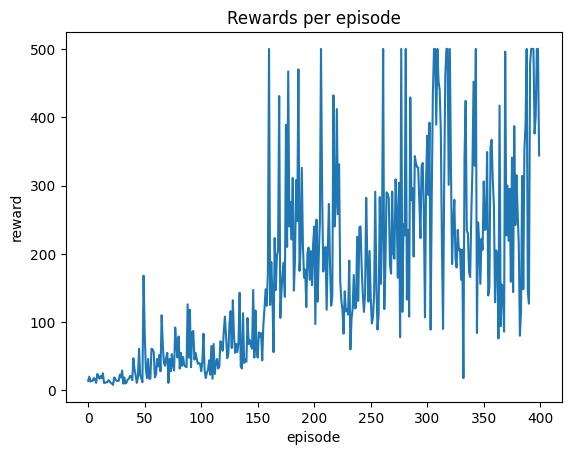

In [ ]:
env = gym.make('CartPole-v1')
trainer = TrainerAC(
    env,
    TrainConfig(),
    PolicyNetworkAC(policy_cfg)
)
trainer.train()
trainer.visualize()

In [ ]:
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), 'video')
state, info = env.reset()
done = False
actions_to_lose = 0

while not done:
  env.render()
  action = trainer.policy.get_action(th.tensor(state))[0]
  actions_to_lose += 1
  state, reward, trunc, term, info = env.step(action)
  done = trunc or term
env.close()
actions_to_lose

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


500

## Обратная связь
- [x] Хочу получить обратную связь по решению